# LSTM-RNN For Sentiment Analysis
Author: Trilby Hren and Costa Huang

Source code vailable at https://github.com/costahuang/Sentiment-Analysis-LSTM

**Our project has three main parts:**
1. Reproduce and understand Keras(a python machine learning library) official demo code on LSTM-RNN for sentiment analysis 
 * [imdb_lstm.py](https://github.com/fchollet/keras/blob/master/examples/imdb_lstm.py) Main program that rains a LSTM on the IMDB sentiment classification task [1]
 * [imdb.py](https://github.com/fchollet/keras/blob/master/keras/datasets/imdb.py) Preprocessing script of IMDB movie review dataset [2]
* Improve the program's accuracy by exploring different techniques:
 * Preprocessing techniques
 * Activation functions
 * Optimizer choices
* Futher application
 * Visualization of sentiment analysis
 * Applied our result to Amazon Review Datas



## Baseline algorithm (Demo code from Keras)
Firstly we execute [imdb_lstm.py](https://github.com/fchollet/keras/blob/master/examples/imdb_lstm.py)[1] and yields following results where a test accuracy of 82.35% is acquired.

In [1]:
'''Trains a LSTM on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
Notes:
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, dropout=0.2))
model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))  # try using a GRU instead, for fun
model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=10,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Using Theano backend.


Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 80)
X_test shape: (25000, 80)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 138s - loss: 0.5333 - acc: 0.7316 - val_loss: 0.4631 - val_acc: 0.7898
Epoch 2/10
25000/25000 [==============================] - 144s - loss: 0.3812 - acc: 0.8358 - val_loss: 0.3776 - val_acc: 0.8370
Epoch 3/10
25000/25000 [==============================] - 147s - loss: 0.3077 - acc: 0.8737 - val_loss: 0.3687 - val_acc: 0.8360
Epoch 4/10
25000/25000 [==============================] - 146s - loss: 0.2497 - acc: 0.8979 - val_loss: 0.4161 - val_acc: 0.8322
Epoch 5/10
25000/25000 [==============================] - 149s - loss: 0.2100 - acc: 0.9180 - val_loss: 0.4277 - val_acc: 0.8330
Epoch 6/10
25000/25000 [==============================] - 151s - loss: 0.1801 - acc: 0.9298 - val_loss: 0.4318 - val_acc: 0.8362
Epoch 7/1

## Understanding the source code
** 1. Preprocessing**
 * Original Dataset is provided by a [Stanford research group](http://ai.stanford.edu/~amaas//data/sentiment/) [3], which provided a set of 25,000 preclassified IMDB movie reviews for training, and 25,000 for testing.
 * [imdb.py](https://github.com/fchollet/keras/blob/master/keras/datasets/imdb.py)[2] performs the following tasks:
     * Download tokenized the IMDB movie review pre-supplied by Keras, where each review is encoded as word indices. An example training review would look like [3, 213, 43, 324, 12, 4, ...] where 3 represents the third most popular word in the dataset.
     * Shuffle the training and testing dataset.
     * Include only *nb_words* most frequent word for ouput
     * Add a [1] to each review to mark the start of the sequence
     * Add a [2] to replace the words that are cut off because of *nb_words*
     * Index actual words with *"index_from = 3*" and higher. (We think this part is **very problematic**, which is mentioned in the next code cell)

In [1]:
# From imdb.py, it has a preprocessing code like this, where they use index_from = 3 as the default parameter
# if start_char is not None:
#     X = [[start_char] + [w + index_from for w in x] for x in X]
index_from = 3
example_review = [6, 499, 6, 99, 221, 9, 22, 501, 2, 3]
example_review = [[1] + [w + index_from for w in example_review]]
print(example_review)

[[1, 9, 502, 9, 102, 224, 12, 25, 504, 5, 6]]


> As we demoed, this particular parameter "shifted" each word index of the review up by *"index_from = 3"*, which is totally nonsense in our opinion because it almost changes everything about that review. We also couldn't find any documentation or papers to support such parameter. As a result, in our experiment, we just simply set *"index_from = 0"*.

**2. Model Building**
 * [imdb_lstm.py](https://github.com/fchollet/keras/blob/master/examples/imdb_lstm.py) builds the model:
     * Limit top most frequent words: Each review only has *"max_features = nb_words = 20000"* most frequent word index
     * Pad Sequence: Each review is padded with a maximum length of *"maxlen = 80"*
     * Embedding layer: Map each word index into *"p = 128"* dimentional vector space
       * The original idea came from this landmark paper [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)[6] where they show a good vector representation for text sequences is achievable.
     * LSTM layer
        * Hochreiter & Schmidhuber [7] first introduced this special kind of RNN to solve the long-term dependency problem. Unlike traditional RNN, LSTM has a memory cell that it uses to determine what information is important by using "forget gate layer" and "input gate layer". [8]
     * Dense(1): fully connect LSTM to create one demensional output
     * Sigmoid
     * Adam optimizer for training.

## Improving the algorithm
**_Activation functions_** by [Keras.layers.core.Activation](https://keras.io/activations/)
1. Sigmoid  
   1. σ(x) = 1/(1+e−x)  
   2. The sigmoid function is a squashing function. We discovered that this activation function jumps up in test accuracy and converges to about 82.6% after 8 generations.     
   
2. ReLU  
  1. f(x) = max(0,x)  
  1. For the ReLU activation function our results show dramatic improvement in later generations. It jumps from very low results to much higher accuracy in both testing and training. The final accuracy is not as good as the results from the sigmoid function, it converges to 73.8% in the last generation.      
  
3. Tanh  
  1. tanh(x) = 2σ(2x)−1tanh(x)=2σ(2x)−1  
  1. The tanh function was slightly better than ReLU with a final accuracy of 77.6%. During our 8 generations, this function seemed to decrease in overall test accuracy perhaps due to overfitting.      
  
4. Hard sigmoid    
  1. The hard sigmoid function performed only slightly better than the sigmoid with a final test accuracy of 83%. From our understanding, it should have converged faster due to increased speed since the precision isn't as important. Perhaps the lower test accuracy is because of the loss in precision rather than the speed.      

[3]
Check out our [Activation functions data](https://docs.google.com/document/d/1uQ49jhYYOmwzSPxYYamTXYCq-07Dhhu75eleew3LBPU/edit?usp=sharing)


**_Optimizer choices_** by [keras.optimizers](https://keras.io/optimizers/)
1. SGD (Stochastic Gradient Decent)
    1. This type of optimizer uses only a few training examples rather than the entire training set. It also can lead to fast convergence since it doesn't have to run back propagation over the full training set. 
    1. Sometimes a meaningful order leads to a bias for the gradient and causes poor convergence. Since `our data was randomly shuffled before each training`, this shouldn't have been an issue.
        2. _Adam_
            1. Adaptive Moment Estimation
            1. This optimizer uses momentum and past gradients to help with learning by combining the two advantages of RMSprop and AdaGrad. 
            1. While we expected this optimizer to perfom the best since it combines the better parts of RMSprop and AdaGrad, it was actually one of our lowest perfoming tests. It showed very slow convergence to 82.6% during our 8 generations. Perhaps it would have converged to a higher accuracy than the others, given a higher number of generations. 
        3. _RMSprop_
            1. Root Mean Square Propagation
            1. This method adapts the learning rate for each parameter by using tha magnitude of recent gradients to normalize the gradients.
            1. From out tests, RSMprop performed the best with a final testing accuracy converging to 84.8%. This optimizer had steady performance through the 8 generations with the lowest accuracy being 82.8%.
        4. _AdaGrad_
            1. Adaptive Gradient Algorithm
            1. AdaGrad adapts to the data in order to chose a learning rate for each feature.
            1. The performance of the AdaGrad optimizer was mediocre, with a final convergence at 83.4%.
        5. _Nadam_
            1. Nesterov Adaptive Moment Estimation
            1. Nadam combines Adam with Nesterov's accelerated gradient.
            1. Our results from this test were one of the lowest with Adam, converging to 82.3% and increasing by a whopping 0.3% over the course of 8 generations.

[4]
Check out our [Optimizer choices data](https://docs.google.com/document/d/1YI5wluhh3rqHs8LBqqL2vOxqNwZdYiPHstWkS2_1s4s/edit?usp=sharing)

** Preprocessing techniques**
1. Change the padding(*"maxlen = 80"*) for each reviews
    1. It is reasonable to assume when people write reviews, they would express their opinion at the start more often than at the end. So we can limit each review to some *"maxlen"* to eliminate noisy data. 
2. Change the top most frequent words(*"max_features = nb_words = 20000"*) for training and testing dataset to keep 
    1. Some words are essential than other words for expressing sentiment. For example, "love" would express more emotion than "keyboard". We therefore limit *"max_features"* to eliminate less sentimentally expresed words.
3. Set *"index_from = 0"* as we explained previously
    
Check out our [Preprocessing techniques data](https://docs.google.com/document/d/1pjZbvzbbHWRUvybd--uTJUhPKvMCjbjxacE3j_zQCM4/edit?usp=sharing)


[0.709, 0.8402]
[0.8205, 0.837]


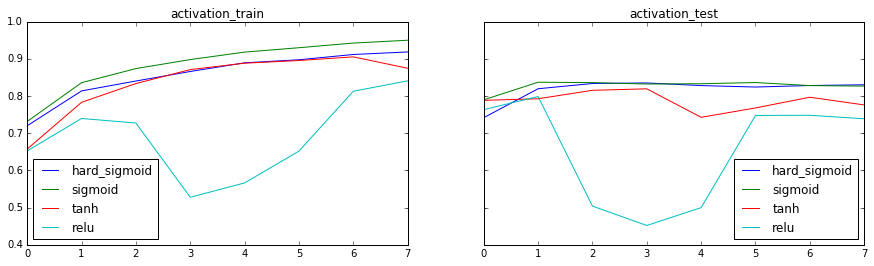

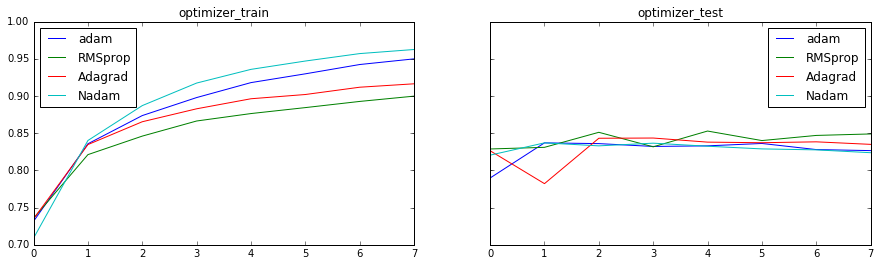

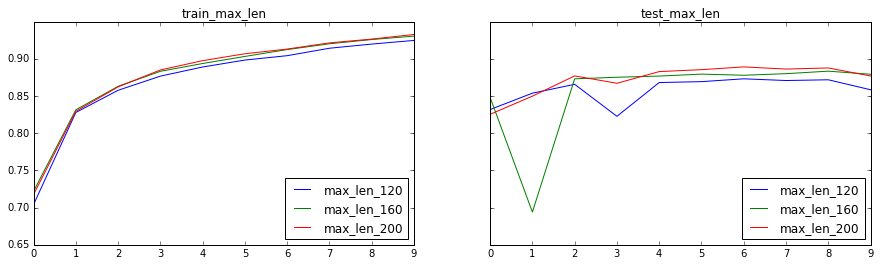

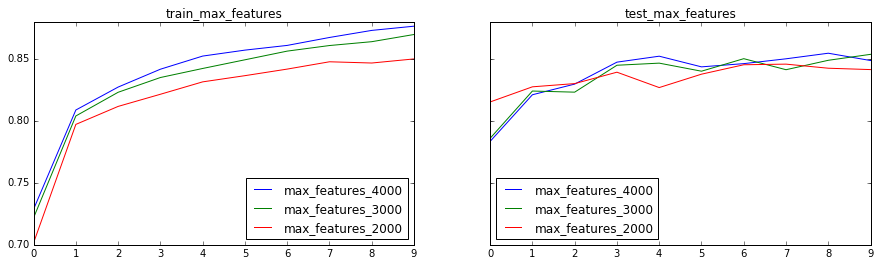

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt

""" get data from model generated text; we further used this script to get datas below. """
model_output = "Epoch 1/8 - acc: 0.7090 - val_acc: 0.8205 Epoch 2/8 - acc: 0.8402 - val_acc: 0.8370 , ...."
data_list = re.findall(r'acc: (\d+\.\d+)', model_output)
data_list = list(map(float, data_list))
print(data_list[::2])
print(data_list[1::2])

""" activation function data """
train_hard_sigmoid = pd.DataFrame({'hard_sigmoid': [0.72,0.8137,0.8403,0.8659,0.8892,0.8974,0.9116,0.9184]})
train_sigmoid = pd.DataFrame({'sigmoid': [0.7316,0.8358,0.8737,0.8979,0.9180,0.9298,0.9423,0.9499]})
train_tanh = pd.DataFrame({'tanh': [0.6574,0.7830,0.8335,0.8710,0.8882,0.8954,0.9052,0.8746]})
train_relu = pd.DataFrame({'relu': [0.6524,0.7396,0.7273,0.5278,0.5663,0.6519,0.8128,0.8407]})
activation_train = pd.concat([train_hard_sigmoid,train_sigmoid,train_tanh,train_relu], axis = 1)

test_hard_sigmoid = pd.DataFrame({'hard_sigmoid': [0.7417,0.8195,0.8336,0.8351,0.8280,0.8241,0.8282,0.8302]})
test_sigmoid = pd.DataFrame({'sigmoid': [0.7898,0.8370,0.8360,0.8322,0.8330,0.8362,0.8280,0.8266]})
test_tanh = pd.DataFrame({'tanh': [0.7883,0.7926,0.8153,0.8193,0.7427,0.7679,0.7967,0.7760]})
test_relu = pd.DataFrame({'relu': [0.7634,0.7986,0.5040,0.4519,0.5000,0.7477,0.7482,0.7388]})
activation_test = pd.concat([test_hard_sigmoid,test_sigmoid, test_tanh, test_relu], axis = 1)


""" optimizer data """
train_adam = pd.DataFrame({'adam': [0.7316, 0.8358, 0.8737, 0.8979, 0.918, 0.9298, 0.9423, 0.9499]})
train_RMSprop = pd.DataFrame({'RMSprop': [0.7357, 0.8212, 0.8461, 0.8664, 0.8764, 0.8844, 0.8927, 0.8998]})
train_Adagrad = pd.DataFrame({'Adagrad': [0.7349, 0.8347, 0.8654, 0.8828, 0.8963, 0.902, 0.9118, 0.9164]})
train_Nadam = pd.DataFrame({'Nadam': [0.709, 0.8402, 0.8871, 0.9174, 0.9358, 0.947, 0.957, 0.9625]})
optimizer_train = pd.concat([train_adam,train_RMSprop,train_Adagrad,train_Nadam], axis = 1)


test_adam = pd.DataFrame({'adam': [0.7898, 0.837, 0.836, 0.8322, 0.833, 0.8362, 0.828, 0.8266]})
test_RMSprop = pd.DataFrame({'RMSprop': [0.8288, 0.831, 0.8512, 0.8317, 0.8529, 0.8401, 0.847, 0.849]})
test_Adagrad = pd.DataFrame({'Adagrad': [0.8264, 0.7822, 0.8432, 0.8435, 0.838, 0.8372, 0.8384, 0.835]})
test_Nadam = pd.DataFrame({'Nadam': [0.8205, 0.837, 0.833, 0.8366, 0.8325, 0.8289, 0.8276, 0.8238]})
optimizer_test = pd.concat([test_adam,test_RMSprop,test_Adagrad,test_Nadam], axis = 1)


""" preprocessing data """
train_max_len_120 = pd.DataFrame({'max_len_120': [0.7041, 0.8279, 0.8577, 0.8767, 0.889, 0.8983, 0.9042, 0.9142, 0.9198, 0.9247]})
train_max_len_160 = pd.DataFrame({'max_len_160': [0.722, 0.8315, 0.863, 0.8832, 0.8937, 0.9032, 0.9124, 0.9202, 0.9259, 0.9305]})
train_max_len_200 = pd.DataFrame({'max_len_200': [0.7176, 0.8294, 0.8623, 0.885, 0.8975, 0.9068, 0.9131, 0.9214, 0.9265, 0.9327]})
train_max_len = pd.concat([train_max_len_120,train_max_len_160,train_max_len_200], axis = 1)

test_max_len_120 = pd.DataFrame({'max_len_120': [0.8318, 0.8538, 0.8657, 0.8227, 0.8681, 0.8693, 0.8731, 0.8708, 0.8718, 0.8584]})
test_max_len_160 = pd.DataFrame({'max_len_160': [0.8481, 0.694, 0.8731, 0.8752, 0.8768, 0.8794, 0.8779, 0.88, 0.8834, 0.8792]})
test_max_len_200 = pd.DataFrame({'max_len_200': [0.8254, 0.8498, 0.877, 0.8671, 0.8828, 0.8854, 0.8891, 0.8862, 0.8877, 0.8769]})
test_max_len = pd.concat([test_max_len_120,test_max_len_160,test_max_len_200], axis = 1)

train_max_features_4000 = pd.DataFrame({'max_features_4000': [0.7287, 0.8087, 0.8272, 0.8416, 0.8522, 0.857, 0.8608, 0.8672, 0.8729, 0.8763]})
train_max_features_3000 = pd.DataFrame({'max_features_3000': [0.7218, 0.8039, 0.823, 0.8349, 0.8422, 0.8492, 0.8562, 0.8607, 0.8638, 0.8696]})
train_max_features_2000 = pd.DataFrame({'max_features_2000': [0.7016, 0.7971, 0.8116, 0.8214, 0.8314, 0.8364, 0.8417, 0.8476, 0.8466, 0.8499]})
train_max_features = pd.concat([train_max_features_4000,train_max_features_3000,train_max_features_2000], axis = 1)

test_max_features_4000 = pd.DataFrame({'max_features_4000': [0.7834, 0.821, 0.8296, 0.8473, 0.8521, 0.8435, 0.8461, 0.85, 0.8545, 0.8486]})
test_max_features_3000 = pd.DataFrame({'max_features_3000': [0.7859, 0.824, 0.8231, 0.8448, 0.8465, 0.84, 0.8501, 0.8412, 0.8488, 0.8536]})
test_max_features_2000 = pd.DataFrame({'max_features_2000': [0.8152, 0.8274, 0.83, 0.8392, 0.8268, 0.8376, 0.8452, 0.8457, 0.8424, 0.8413]})
test_max_features = pd.concat([test_max_features_4000,test_max_features_3000,test_max_features_2000], axis = 1)

""" plotting """
%matplotlib inline
f1, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f1.set_figwidth(15)
activation_train.plot(ax = ax1, title = "activation_train")
activation_test.plot(ax = ax2, title = "activation_test")

f2, (ax3, ax4) = plt.subplots(1, 2, sharey=True)
f2.set_figwidth(15)
optimizer_train.plot(ax = ax3,title = "optimizer_train")
optimizer_test.plot(ax = ax4,title = "optimizer_test")

f3, (ax5, ax6) = plt.subplots(1, 2, sharey=True)
f3.set_figwidth(15)
train_max_len.plot(ax = ax5,title = "train_max_len")
test_max_len.plot(ax = ax6,title = "test_max_len")

f4, (ax7, ax8) = plt.subplots(1, 2, sharey=True)
f4.set_figwidth(15)
train_max_features.plot(ax = ax7,title = "train_max_features")
test_max_features.plot(ax = ax8,title = "test_max_features")

## Building New Model 
After such comparision, we decided to build model using *RMSprop* optimizer, *sigmoid* activation function, *max_features* = 3000, and *max_len*= 200.

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.layers.wrappers import TimeDistributed
import pickle
from six.moves import cPickle
import pandas as pd
import math
import matplotlib.pyplot as plt


max_features = 3000
maxlen = 200  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(XX_train, y_train), (XX_test, y_test) = imdb.load_data(path='imdb_full.pkl', nb_words=max_features, skip_top=10,
              maxlen=None, seed=113,
              start_char=1, oov_char=2, index_from=0)
print(len(XX_train), 'train sequences')
print(len(XX_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(XX_train, maxlen=maxlen)
X_test = sequence.pad_sequences(XX_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, dropout=0.2))
model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))  # try using a GRU instead, for fun
model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=10,
          validation_data=(X_test, y_test))

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
X_train shape: (25000, 200)
X_test shape: (25000, 200)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 288s - loss: 0.5716 - acc: 0.6874 - val_loss: 0.3979 - val_acc: 0.8376
Epoch 2/10
25000/25000 [==============================] - 289s - loss: 0.4373 - acc: 0.8071 - val_loss: 0.3447 - val_acc: 0.8603
Epoch 3/10
25000/25000 [==============================] - 297s - loss: 0.3914 - acc: 0.8336 - val_loss: 0.3410 - val_acc: 0.8577
Epoch 4/10
25000/25000 [==============================] - 301s - loss: 0.3526 - acc: 0.8508 - val_loss: 0.3228 - val_acc: 0.8604
Epoch 5/10
25000/25000 [==============================] - 305s - loss: 0.3224 - acc: 0.8631 - val_loss: 0.2915 - val_acc: 0.8782
Epoch 6/10
25000/25000 [==============================] - 302s - loss: 0.3031 - acc: 0.8756 - val_loss: 0.3119 - val_acc: 0.8671
Epoch 7

As we can see, our new model has a better prediction of 88.75% accuracy versus the original model.

## Further Applications
Visualization of sentiment analysis ,inspired by [Taylor Arnold's jupyter notebook](http://euler.stat.yale.edu/~tba3/stat665/lectures/lec21/notebook21.html) [9]

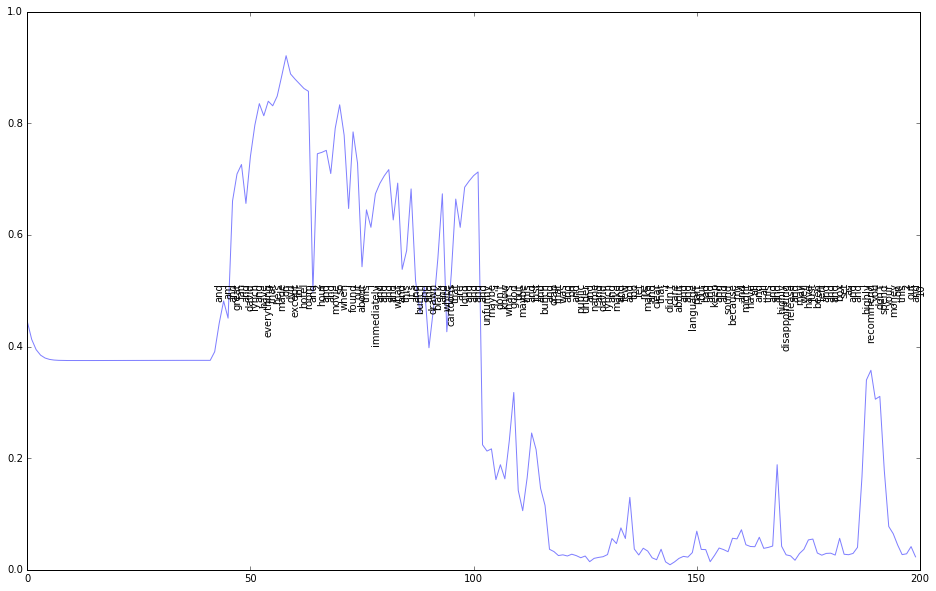

In [4]:
%matplotlib inline
from keras.layers.wrappers import TimeDistributed
import pickle
from six.moves import cPickle
import pandas as pd
import math
import matplotlib.pyplot as plt

def reconstruct_text(index, index_to_word):
    text = []
    for ind in index:
        if ind != 0:
            text += [index_to_word[ind]]
        else:
            text += [""]
    return text

word_to_index = imdb.get_word_index()
index_to_word = {k:v for v,k in word_to_index.items()}
f = open('imdb_full.pkl', 'rb')
(x_train, labels_train), (x_test, labels_test) = cPickle.load(f)
f.close()
df = pd.DataFrame(x_train)

model2 = Sequential()
model2.add(Embedding(max_features, 128, dropout=0.2))
model2.add(LSTM(128, dropout_W=0.2, dropout_U=0.2, return_sequences=True))  # try using a GRU instead, for fun
model2.add(TimeDistributed(Dense(1)))
model2.add(Activation('sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model2.set_weights(model.get_weights())
y_hat2 = model2.predict(X_train)

ind = 100
tokens = reconstruct_text(X_train[ind], index_to_word)

plt.figure(figsize=(16, 10))
plt.plot(y_hat2[ind],alpha=0.5)
for i in range(len(tokens)):
    plt.text(i,0.5,tokens[i],rotation=90)

## Apply Current Model to Amazon Review Data
Now that we have successfully improved the model, we further apply our new model to Amazon Review data provided by Dr. Allen.
Amazon Review Dataset has preclassified sentiment value on 6 categories: books, camera, dvd, health, music, software. We need to complie data in a specific way so that our current model can directly use it.

### 1. Change File Structure
We will split the reviews into training set and testing set by changing the file structure

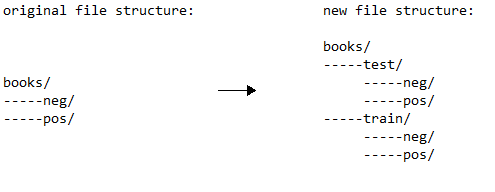

In [5]:
from IPython.display import Image
i = Image(filename='file_structure.png')
i

### 2. Preprocess Amazon Reviews
**Load reviews:**

In [6]:
from six.moves import cPickle
import numpy
import os
import pandas as pd
import string
from collections import Counter
from keras.preprocessing.text import Tokenizer

path = ["books/", "camera/", "dvd/", "health/", "music/", "software/"]  # camera, has missing data
ff = []
input_label = []
for i in range(6):
    ff += [path[i] + "train/pos/" + x for x in os.listdir(path[i] + "train/pos")] + \
         [path[i] + "train/neg/" + x for x in os.listdir(path[i] + "train/neg")] + \
         [path[i] + "test/pos/" + x for x in os.listdir(path[i] + "test/pos")] + \
         [path[i] + "test/neg/" + x for x in os.listdir(path[i] + "test/neg")]
    
    # Because of missing data, we need to measure how many reviews are there in each folder in order to label them correctly.
    train_pos = len(os.listdir(path[i] + "train/pos"))
    train_neg = len(os.listdir(path[i] + "train/neg"))
    test_pos = len(os.listdir(path[i] + "test/pos"))
    test_neg = len(os.listdir(path[i] + "test/neg"))
    input_label += [1] * train_pos + [0] * train_neg + [1] * test_pos + [0] * test_neg
    
      
input_text  = []
for f in ff:
    with open(f, 'rb') as fin:
        temp = fin.read().splitlines()
        x = " ".join([x.decode("utf-8", errors = 'ignore') for x in temp])
        input_text += [x]
        
print(input_text[0])

I wish I could give this book four and a half stars instead of four; I can't quite justify five stars in my mind.  Two of the stories were definitely good: the first, "masked Riders" by Parhelion, and the third, "Ricochet" by BA Tortuga.  I enjoyed both, but was not particularly snowed by the intensity of the conflict/plot line or the main characters and their relationships.  Not so the second story: "Hung Up" by Cat Kane was a powerful, intense and moving story about two delightful yet flawed characters who had secrets that tore their relationship up until they were able to work their ways (separately) around the issues.  That story deserved a five stars plus rating and I wish Kane would turn it into a full length novel and develop the characters and their backgrounds more.  This book is an excellent read both for the plot line and the erotic substance.  Enjoy


**Tokenize reviews:**

In [7]:
input_text  = []
for f in ff:
    with open(f, 'rb') as fin:
        temp = fin.read().splitlines()
        x = " ".join([x.decode("utf-8", errors = 'ignore') for x in temp])
        input_text += [x]

cut_index = int(len(input_text)/2)
tok = Tokenizer()
tok.fit_on_texts(input_text[:cut_index])

X_train = tok.texts_to_sequences(input_text[:cut_index])
X_test  = tok.texts_to_sequences(input_text[cut_index:])
y_train = input_label[:cut_index]
y_test  = input_label[cut_index:]

print("As you can see, the first review has been encoded as their word index:")
print(X_train[0][:10])

As you can see, the first review has been encoded as their word index:
[6, 499, 6, 99, 221, 9, 22, 501, 2, 3]


**Reconstruct reviews:**

In [8]:
words = {k:v for v,k in tok.word_index.items()}
def reconstruct_text(index, words):
    text = []
    for ind in index:
        if ind != 0:
            text += [words[ind]]
        else:
            text += [""]
    return text
    
print(input_text[100])
print(reconstruct_text(X_train[100], words))

Peck relates growing up in rural/small town Vermont with a best friend who gets him into lots of trouble. Humor and pranks abound in between lessons learned
['peck', 'relates', 'growing', 'up', 'in', 'rural', 'small', 'town', 'vermont', 'with', 'a', 'best', 'friend', 'who', 'gets', 'him', 'into', 'lots', 'of', 'trouble', 'humor', 'and', 'pranks', 'abound', 'in', 'between', 'lessons', 'learned']


**Store reviews: **

In [9]:
f = open('amzn_full.pkl', 'wb')
train_tuple = (X_train, y_train)
test_tuple = (X_test, y_test)
combine = (train_tuple, test_tuple)
cPickle.dump(combine, f)
f.close()

### 3. Apply Current Model to Amazon Reviews:
Firstly we need to make a copy of [imdb.py](https://github.com/fchollet/keras/blob/master/keras/datasets/imdb.py)(the script that loads imdb_full.pkl data) and make it loads our amzn_full.pkl instead. Name the new file amzn.py. Then we apply our model:

In [10]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
import amzn
from keras.layers.wrappers import TimeDistributed
import pickle
from six.moves import cPickle
import pandas as pd
import math
import matplotlib.pyplot as plt


max_features = 3000
maxlen = 200  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(XX_train, y_train), (XX_test, y_test) = amzn.load_data(path='amzn_full.pkl', nb_words=max_features)
print(len(XX_train), 'train sequences')
print(len(XX_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(XX_train, maxlen=maxlen)
X_test = sequence.pad_sequences(XX_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, dropout=0.2))
model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))  # try using a GRU instead, for fun
model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=10,
          validation_data=(X_test, y_test))

Loading data...
5957 train sequences
5957 test sequences
Pad sequences (samples x time)
X_train shape: (5957, 200)
X_test shape: (5957, 200)
Build model...
Train...
Train on 5957 samples, validate on 5957 samples
Epoch 1/10
5957/5957 [==============================] - 63s - loss: 0.6823 - acc: 0.5587 - val_loss: 0.6493 - val_acc: 0.6325
Epoch 2/10
5957/5957 [==============================] - 63s - loss: 0.5696 - acc: 0.7082 - val_loss: 0.5350 - val_acc: 0.7386
Epoch 3/10
5957/5957 [==============================] - 68s - loss: 0.4870 - acc: 0.7692 - val_loss: 0.5081 - val_acc: 0.7480
Epoch 4/10
5957/5957 [==============================] - 70s - loss: 0.4290 - acc: 0.8054 - val_loss: 0.8713 - val_acc: 0.6157
Epoch 5/10
5957/5957 [==============================] - 60s - loss: 0.3910 - acc: 0.8348 - val_loss: 0.5099 - val_acc: 0.7646
Epoch 6/10
5957/5957 [==============================] - 60s - loss: 0.3738 - acc: 0.8385 - val_loss: 0.5034 - val_acc: 0.7702
Epoch 7/10
5957/5957 [=========

## Compare Result to Original Model

In [11]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
import amzn

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(X_train, y_train), (X_test, y_test) = amzn.load_data(path='amzn_full.pkl', nb_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128, dropout=0.2))
model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))  # try using a GRU instead, for fun
model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=10,
          validation_data=(X_test, y_test))

Loading data...
5957 train sequences
5957 test sequences
Pad sequences (samples x time)
X_train shape: (5957, 80)
X_test shape: (5957, 80)
Build model...
Train...
Train on 5957 samples, validate on 5957 samples
Epoch 1/10
5957/5957 [==============================] - 31s - loss: 0.6641 - acc: 0.5949 - val_loss: 0.5708 - val_acc: 0.7077
Epoch 2/10
5957/5957 [==============================] - 31s - loss: 0.4679 - acc: 0.7823 - val_loss: 0.5437 - val_acc: 0.7326
Epoch 3/10
5957/5957 [==============================] - 31s - loss: 0.3293 - acc: 0.8687 - val_loss: 0.5521 - val_acc: 0.7521
Epoch 4/10
5957/5957 [==============================] - 31s - loss: 0.2428 - acc: 0.9077 - val_loss: 0.5821 - val_acc: 0.7601
Epoch 5/10
5957/5957 [==============================] - 31s - loss: 0.1790 - acc: 0.9347 - val_loss: 0.7185 - val_acc: 0.7408
Epoch 6/10
5957/5957 [==============================] - 31s - loss: 0.1270 - acc: 0.9542 - val_loss: 0.7469 - val_acc: 0.7519
Epoch 7/10
5957/5957 [===========

In [1]:
%%html
<style>
table {float:left}
</style>

# Conclusion
Our new model is based on two main hypothesis:
 1. It is reasonable to assume when people write reviews, they would express their opinion at the start more often than at the end. So we can limit each review to some *"maxlen"* to eliminate noisy data. 
 2. Some words are essential than other words for expressing sentiment. For example, "love" would express more emotion than "keyboard". We therefore limit *"max_features"* to eliminate less sentimentally expresed words.


Therefore by experimenting different *"maxlen"*, *"max_features"* , and optimizers, our new model improves the prediction accuracy on both IMDB and Amazon Review dataset, hence validating our hypothesis.



|                        | Original Model Provided by Keras| Our New Model
| :------                | :-----------                    | ----       |
| **Amazon Review **     | 73.34%                          | 78.90%     |
| **IMDB Movie Review ** | 82.35%                          | 88.75%     |

# Reference


[1] Fran¸cois Chollet. Keras. [imdb_lstm.py](https://github.com/fchollet/keras/blob/master/examples/imdb_lstm.py), 2015 

[2] Fran¸cois Chollet. Keras. [imdb.py](https://github.com/fchollet/keras/blob/master/keras/datasets/imdb.py), 2015 

[3] "Convolutional Neural Networks for Visual Recognition." Web. 06 Dec. 2016. (http://cs231n.github.io/neural-networks-1).

[4] Ruder, Sebastian. "An Overview of Gradient Descent Optimization Algorithms." 30 Sept. 2016. Web. (http://sebastianruder.com/optimizing-gradient-descent/).

[5] Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas//papers/wvSent_acl2011.pdf). *The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)*, 2011

[6] T Mikolov, I Sutskever, K Chen, GS Corrado, J Dean - Advances in neural information processing systems, [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf), 2013

[7] Hochreiter, S., & Schmidhuber, J. [Long short-term memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf). Neural computation, 9(8), 1735-1780. 1997

[8] Olah C [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), 2015

[9] Arnold T, *STAT 365/665: Data Mining and Machine Learning*, [Recurrent neural networks](http://euler.stat.yale.edu/~tba3/stat665/lectures/lec21/notebook21.html), 2016